In [1]:
# import necessary libraries

# PyTorch based
import torch as pt
from torch import nn
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor # converts pil imag3e or np array to FloatTensor of shape (C x H x W)
import torchmetrics as tm

# Matplotlib for visualization
import matplotlib.pyplot as plt

print(pt.__version__)
print(tv.__version__)


import importLib
importLib.import_from_github("https://raw.githubusercontent.com/GGisMee/PyTorch/main/ml_toolkit/helper_functions.py")
importLib.import_from_github("https://raw.githubusercontent.com/GGisMee/PyTorch/main/ml_toolkit/ml_funcs.py")


C:\Users\22gusgam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


2.0.1+cu118
0.15.2+cu118
c:\Users\22gusgam\Desktop\programmering\PyTorch\03/helper_functions.py already exists
c:\Users\22gusgam\Desktop\programmering\PyTorch\03/ml_funcs.py doesn't exist, download


True

### 1. Getting a dataset

The dataset we will be using is FashionMNIST from torchvision.datasets, (a dataset of gray scale images of clothing): https://pytorch.org/vision/main/datasets.html

In [2]:
# Setup training data
import os
print(os.getcwd())
train_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data", # where should the file be placed
    train=True, # do we want to get the training dataset
    download=True, # do we want to download the dataset
    transform=ToTensor(), # how do we want to transform the data, 
    target_transform=None # how do we want to transform the labels/targets
    )

test_data = datasets.FashionMNIST(
    root=f"{os.getcwd()}/data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
    )

c:\Users\22gusgam\Desktop\programmering\PyTorch\03


In [3]:
print(len(train_data),len(test_data))

60000 10000


### Visualizing our dataset

#### As numbers

In [4]:
train_data.data.shape # batch size of 60000

torch.Size([60000, 28, 28])

In [5]:
# See the first training example
image, label = train_data[0]
class_names = train_data.classes
class_names[label]

'Ankle boot'

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
# Check the shape of our image
print(f"image shape{image.shape} -> [Color channels, height, width]")
print(f"image_label: {class_names[label]}")

image shapetorch.Size([1, 28, 28]) -> [Color channels, height, width]
image_label: Ankle boot


#### As pictures

image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot, 9')

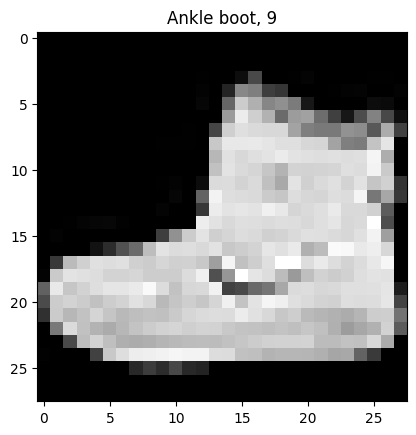

In [8]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap=plt.cm.gray)
plt.title(f"{class_names[label]}, {label}")

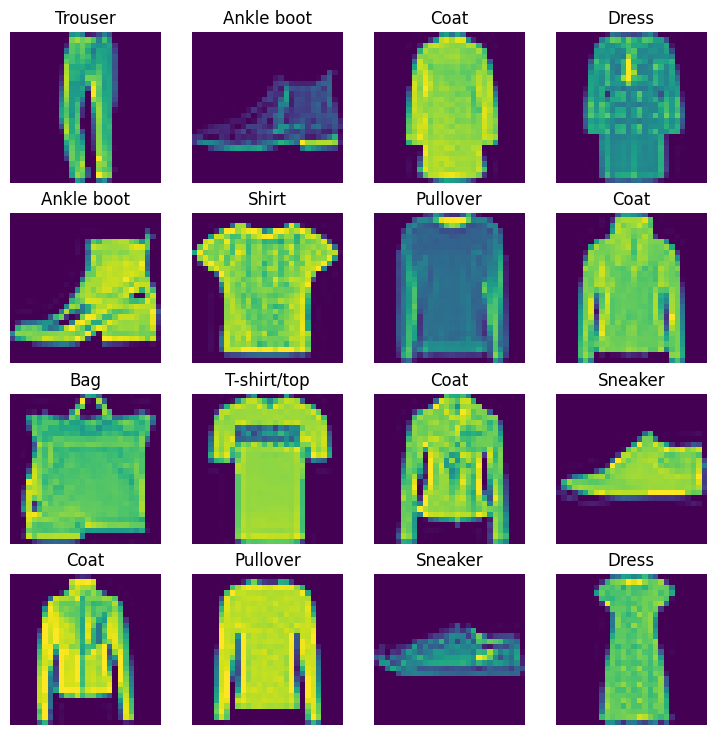

In [9]:
# Plot more images

#pt.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = pt.randint(0, len(train_data), size=[1]).item()
    #print(random_idx,i)
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()) #, cmap="gray"
    plt.title(class_names[label])
    plt.axis(False)

Is non linearity necessary or not?

### Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets

DataLoaders turn our dataset into a Python iterable
more specifically, we want to turn our data into batches i.e mini-batches

Why do this?
1. It is more computationally efficient, as your computer may not be able to store 60000 images at the same time, therefore we brake it down to ex 32 images at a time (batch size)
2. it gives our nn more chances to update its gradient per epoch (update for each 32 images)

In [10]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into a generator like BataLoader that generates batches
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True) # shuffle = True gör att alla värden i arrayen blandas
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)





In [11]:
# Let's check out the dataloader
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001FD15F9BBD0>, <torch.utils.data.dataloader.DataLoader object at 0x000001FD15F734D0>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [12]:
# Check out what's inside the training dataloader
train_features_batch, training_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, training_labels_batch.shape
# [32 batches, 1 color channel, 28 by, 28 pixels], 32 labels associated with the train_data

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

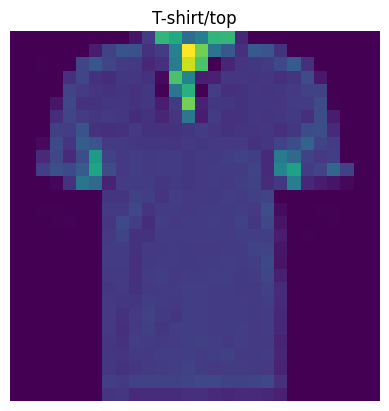

In [13]:
# Show a sample
pt.manual_seed(42)
random_idx = pt.randint(0, len(train_features_batch), size = [1]).item()
img, label = train_features_batch[random_idx], training_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label.item()])
plt.axis(False)


### Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets

CNN's are known for their capabilities to find patterns in visual data

Typical architecture of CNN:
Inputs -> ToTensor -> (CNN & ReLU & Pooling) layers -> output